In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib

/Users/sebastian/anaconda/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using matplotlib backend: MacOSX


[19  5 16 13 18 11 14  8  9 12  2  4  0  7  1 15 10 17  3  6]


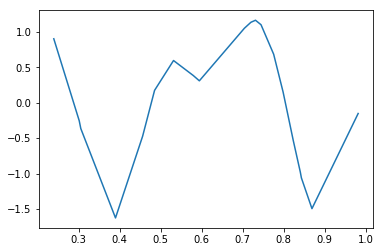

In [2]:
with gpflow.defer_build():
    X = np.random.rand(20, 1)
    Y = np.sin(12 * X) + 0.66 * np.cos(25 * X) + np.random.randn(20,1) * 0.01
    m = gpflow.models.GPR(X, Y, 
                         kern=gpflow.kernels.Matern32(1) + gpflow.kernels.Linear(1))
    
    X = X.reshape(-1)
    sort_args = np.argsort(X)
    print(sort_args)
    plt.plot(X[sort_args],Y[sort_args])

In [4]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/matern32/variance,Parameter,None,+ve,True,(),True,1.0
GPR/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/linear/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0


In [5]:
m.likelihood.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0


In [6]:
m.kern.matern32.lengthscales = 0.5
m.likelihood.variance = 0.01
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/matern32/variance,Parameter,None,+ve,True,(),True,1.0
GPR/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,0.5
GPR/kern/linear/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [7]:
m.read_trainables()

{'GPR/kern/linear/variance': array(1.),
 'GPR/kern/matern32/lengthscales': array(0.5),
 'GPR/kern/matern32/variance': array(1.),
 'GPR/likelihood/variance': array(0.01)}

In [8]:
m.kern.matern32.variance.prior = gpflow.priors.Gamma(2,3)
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/matern32/variance,Parameter,"Ga([2.],[3.])",+ve,True,(),True,1.0
GPR/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,0.5
GPR/kern/linear/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [9]:
m.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2.092039
  Number of iterations: 52
  Number of functions evaluations: 56


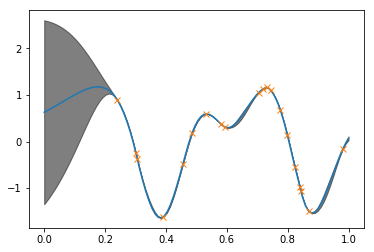

In [10]:
test_X = np.linspace(0,1,100)
Y_mean, Y_std = m.predict_y(test_X.reshape(-1,1))
# print(test_Y)
plt.figure()
plt.plot(test_X, Y_mean)
Y_mean = Y_mean.reshape(-1)
Y_std = Y_std.reshape(-1)
# print(test_Y[0] - test_Y[1])
plt.plot(X, Y, 'x')
plt.fill_between(test_X, Y_mean - Y_std, Y_mean + Y_std, alpha=0.5, color='k')

# Multi-class classification

In [11]:
from matplotlib import pyplot as plt
%matplotlib
plt.style.use('ggplot')
import tensorflow as tf
import numpy as np
import gpflow

import keras
from keras.datasets import mnist

Using matplotlib backend: MacOSX


Using TensorFlow backend.


## Generate the data

In [12]:
X = np.random.rand(100, 1)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(100) * 1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(100, 3))

plt.figure(figsize=(12,6))
plt.plot(X, f, '.')
Y = np.array(np.argmax(f, 1).reshape(-1,1), dtype=float)

## Sparse Variational Gaussian approximation

In [13]:
%%time
kernel = gpflow.kernels.Matern32(1) + gpflow.kernels.White(1, variance=0.01)
likelihood = gpflow.likelihoods.MultiClass(3)
Z=X[::5].copy()
num_latent=3
whiten=True
q_diag=True
m = gpflow.models.SVGP(X, Y, 
                       kern=kernel, 
                       likelihood=likelihood,
                       Z=Z, 
                       num_latent=num_latent,
                       whiten=whiten, 
                       q_diag=q_diag)

m.kern.white.variance.trainable = False
m.feature.trainable = False
m.as_pandas_table()

CPU times: user 505 ms, sys: 8.28 ms, total: 513 ms
Wall time: 516 ms


In [14]:
%%time
opt = gpflow.train.AdamOptimizer()
opt.minimize(m)

CPU times: user 11.4 s, sys: 1.76 s, total: 13.1 s
Wall time: 5.1 s


In [17]:
%matplotlib
def plot(m):
    fig = plt.figure(figsize=(12, 6))
    a0 = fig.add_axes([0.05, 0.05, 0.9, 0.25])
    a0.set_title("Data points")
    a1 = fig.add_axes([0.05, 0.35, 0.9, 0.25])
    a1.set_title("Latent functions")
    a2 = fig.add_axes([0.05, 0.65, 0.9, 0.1])
    a2.set_title("Probabilities")
    a3 = fig.add_axes([0.05, 0.8, 0.9, 0.1])
    a3.set_title("Assigned class")
    
    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1, 1)
    mu, var = m.predict_f(xx)
    mu, var = mu.copy(), var.copy()
    p, _ = m.predict_y(xx)
    
    a0.plot(X, f, '.')
    
    a1.set_xticks([])
    a3.set_xticks([])
    a3.set_yticks([])
    
    for i in range(m.likelihood.num_classes):
        x = m.X.read_value()[m.Y.read_value().flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color = points.get_color()
        a1.plot(xx, mu[:,i], color=color, lw=2)
        a1.plot(xx, mu[:,i] + 2*np.sqrt(var[:,i]), '--', color=color)
        a1.plot(xx, mu[:,i] - 2*np.sqrt(var[:,i]), '--', color=color)        
        a2.plot(xx, p[:, i], '-', color=color, lw=2)
        
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0,1])
    a2.set_xticks([])
plot(m)

Using matplotlib backend: MacOSX


In [41]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/matern32/variance,Parameter,None,+ve,True,(),True,144.33355013015506
SVGP/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,0.3748351970926175
SVGP/kern/white/variance,Parameter,None,+ve,False,(),True,0.01


## Sparse MCMC

In [40]:
with gpflow.defer_build():
    kernel = gpflow.kernels.Matern32(1, lengthscales=0.1) + gpflow.kernels.White(1, variance=0.01)
    likelihood = gpflow.likelihoods.MultiClass(3)
    Z=X[::5].copy()
    num_latent=3
    m = gpflow.models.SGPMC(X, Y,
                        kern=kernel,
                           likelihood=likelihood,
                           Z=Z,
                           num_latent=num_latent)

    m.kern.matern32.variance.prior = gpflow.priors.Gamma(1.,1.)
    m.kern.matern32.lengthscales.prior = gpflow.priors.Gamma(2.,2.)
    m.kern.white.variance.trainables = False
m.compile()

In [58]:
with gpflow.defer_build():
    m = gpflow.models.SGPMC(X, Y,
                     kern=gpflow.kernels.Matern32(1, lengthscales=0.1) + gpflow.kernels.White(1, variance=0.01),
                     likelihood=gpflow.likelihoods.MultiClass(3),
                     Z=X[::5].copy(), num_latent=3)
    m.kern.matern32.variance.prior = gpflow.priors.Gamma(1.,1.)
    m.kern.matern32.lengthscales.prior = gpflow.priors.Gamma(2.,2.)
    m.kern.white.variance.trainable = False

m.compile()
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SGPMC/kern/matern32/variance,Parameter,"Ga([1.],[1.])",+ve,True,(),True,1.0
SGPMC/kern/matern32/lengthscales,Parameter,"Ga([2.],[2.])",+ve,True,(),True,0.1
SGPMC/kern/white/variance,Parameter,None,+ve,False,(),True,0.01


In [61]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, maxiter=100)
m.kern.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 113.767618
  Number of iterations: 101
  Number of functions evaluations: 135


,class,prior,transform,trainable,shape,fixed_shape,value
SGPMC/kern/matern32/variance,Parameter,"Ga([1.],[1.])",+ve,True,(),True,1.906417065167978
SGPMC/kern/matern32/lengthscales,Parameter,"Ga([2.],[2.])",+ve,True,(),True,0.08955672742336324
SGPMC/kern/white/variance,Parameter,None,+ve,False,(),True,0.01


In [62]:
#use hamiltonian monte carle to obtain samples
hmc = gpflow.train.HMC()
samples = hmc.sample(m, 
                     num_samples=500, 
                     epsilon=0.04,
                     lmax=15,
                     logprobs=False)

In [16]:
def plot_from_samples(m, samples):
    fig = plt.figure(figsize=(12, 6))
    a0 = fig.add_axes([0.05, 0.05, 0.9, 0.25])
    a0.set_title("Data points")
    a1 = fig.add_axes([0.05, 0.35, 0.9, 0.25])
    a1.set_title("Latent functions")
    a2 = fig.add_axes([0.05, 0.65, 0.9, 0.1])
    a2.set_title("Probabilities")
    a3 = fig.add_axes([0.05, 0.8, 0.9, 0.1])
    a3.set_title("Assigned class")
    
    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1, 1)
    
    Fpred, Ypred = [], []
    #burn in time of 100, thin time of 10
    for s in samples[100::10].iterrows():
        m.assign(s[1])
        Ypred.append(m.predict_y(xx)[0])
        Fpred.append(m.predict_f_samples(xx, 1).squeeze())
    
    
    for i in range(m.likelihood.num_classes):
        x = m.X.read_value()[m.Y.read_value().flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color = points.get_color()
        for F in Fpred:
            a1.plot(xx, F[:,i], color=color, lw=0.2, alpha=1.0)
        for Y in Ypred:
            a2.plot(xx, Y[:,i], color=color, lw=0.5, alpha=1.0)

    a0.plot(X, f, '.')    
    a1.set_xticks([])
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0,1])
    a2.set_xticks([])
    a3.set_xticks([])
    a3.set_yticks([])
plot_from_samples(m, samples)

NameError: name 'samples' is not defined

In [64]:
samples.head()

,SGPMC/V,SGPMC/feature/Z,SGPMC/kern/matern32/lengthscales,SGPMC/kern/matern32/variance
0,"[[2.2777814408983783, 0.3865348539167041, -2.6...","[[0.46808490252962015], [0.5990443732026893], ...",0.089557,1.906417
1,"[[2.2777814408983783, 0.3865348539167041, -2.6...","[[0.46808490252962015], [0.5990443732026893], ...",0.089557,1.906417
2,"[[2.2777814408983783, 0.3865348539167041, -2.6...","[[0.46808490252962015], [0.5990443732026893], ...",0.089557,1.906417
3,"[[2.2777814408983783, 0.3865348539167041, -2.6...","[[0.46808490252962015], [0.5990443732026893], ...",0.089557,1.906417
4,"[[2.2777814408983783, 0.3865348539167041, -2.6...","[[0.46808490252962015], [0.5990443732026893], ...",0.089557,1.906417
